# Step 2: Clean Up Data

In the previous step, the data was explored and it was found that the patterns in the data are quite different for each vendor. Therefore, in this notebook the data is cleaned up and analyzed for a specific vendor - Seagate. Seagate is chosen because it forms the majority in the backblaze dataset (~7M out of ~9M points).

The clean up in this notebook mainly consists of removing/replacing NaN values intelligently.

In [10]:
import gc
import os
import sys
SRC_PATH = '../src'
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
import utils

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [2]:
# register progress bar for compute calls in dask so we have an estimate of how long task will take
pbar = ProgressBar()
pbar.register()

In [3]:
# inferred int32 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_11_normalized": "float32",
    "smart_11_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_13_normalized": "float32",
    "smart_13_raw": "float32",
    "smart_15_normalized": "float32",
    "smart_15_raw": "float32",
    "smart_16_normalized": "float32",
    "smart_16_raw": "float32",
    "smart_17_normalized": "float32",
    "smart_17_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_23_normalized": "float32",
    "smart_23_raw": "float32",
    "smart_24_normalized": "float32",
    "smart_24_raw": "float32",
    "smart_168_normalized": "float32",
    "smart_168_raw": "float32",
    "smart_170_normalized": "float32",
    "smart_170_raw": "float32",
    "smart_173_normalized": "float32",
    "smart_173_raw": "float32",
    "smart_174_normalized": "float32",
    "smart_174_raw": "float32",
    "smart_177_normalized": "float32",
    "smart_177_raw": "float32",
    "smart_179_normalized": "float32",
    "smart_179_raw": "float32",
    "smart_181_normalized": "float32",
    "smart_181_raw": "float32",
    "smart_182_normalized": "float32",
    "smart_182_raw": "float32",
    "smart_183_normalized": "float32",
    "smart_183_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_191_normalized": "float32",
    "smart_191_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_195_normalized": "float32",
    "smart_195_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32",
    "smart_200_normalized": "float32",
    "smart_200_raw": "float32",
    "smart_201_normalized": "float32",
    "smart_201_raw": "float32",
    "smart_218_normalized": "float32",
    "smart_218_raw": "float32",
    "smart_220_normalized": "float32",
    "smart_220_raw": "float32",
    "smart_222_normalized": "float32",
    "smart_222_raw": "float32",
    "smart_223_normalized": "float32",
    "smart_223_raw": "float32",
    "smart_224_normalized": "float32",
    "smart_224_raw": "float32",
    "smart_225_normalized": "float32",
    "smart_225_raw": "float32",
    "smart_226_normalized": "float32",
    "smart_226_raw": "float32",
    "smart_231_normalized": "float32",
    "smart_231_raw": "float32",
    "smart_232_normalized": "float32",
    "smart_232_raw": "float32",
    "smart_233_normalized": "float32",
    "smart_233_raw": "float32",
    "smart_235_normalized": "float32",
    "smart_235_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
    "smart_250_normalized": "float32",
    "smart_250_raw": "float32",
    "smart_251_normalized": "float32",
    "smart_251_raw": "float32",
    "smart_252_normalized": "float32",
    "smart_252_raw": "float32",
    "smart_254_normalized": "float32",
    "smart_254_raw": "float32",
    "smart_255_normalized": "float32",
    "smart_255_raw": "float32",
}

In [4]:
# read all the data into one dataframe
DATA_DIR = '/home/kachauha/Downloads/data_Q3_2018'
df = dd.read_csv(os.path.join(DATA_DIR, '*.csv'), dtype=custom_dtypes)

In [5]:
# get the seagate data
seagate_df = df[df['model'].str.startswith('S')]

In [6]:
# get the serial numbers for all the failed hard drives
failed_serials = seagate_df[seagate_df['failure']==1]['serial_number'].compute()

[########################################] | 100% Completed | 36.1s


**NOTE:** Can also add date of failure, and its model to failed_serials (and working_serials) if it will be helpful for preprocessing in the future.

In [15]:
# get the serial numbers for all the failed hard drives, date of failure, and its model
# multiple entries will exist per serial number since it will be a time series. get only the last one
working_serials = seagate_df[~seagate_df['serial_number'].isin(failed_serials)]\
                    ['serial_number']\
                    .drop_duplicates(keep='last')\
                    .compute()

[########################################] | 100% Completed | 51.3s


2203    Z300XGTR
4389    Z300XA99
4900    Z3015BTR
6971    Z300WWNK
8459    Z30149AZ
Name: serial_number, dtype: object

**NOTE:** We can probably get away with not calculating working serials and instead using not failed_serials for indexing. this will be much faster and efficient since we are searching in ~300 drives as oppospsed to ~80k drives.

## Ensure Unique Indices

Having a unique index per entry (e.g. 2018-10-01 Z305B2QN) will make data processing less prone to errors. It will also expand the variety of merging and groupby operations that can be done on the data while still keeping it a dask dataframe (vs pandas dataframe). This is because some operations in dask require do not support duplicate indices.

In [7]:
# # are there any duplicate indices? [SPOILER ALERT] yes
# tmp = seagate_df.index.compute()
# tmp.duplicated().any()    # True

# # can reset indices do the job?
# # no. see dask docs. indices are duplicated across dask partitions
# seagate_df = seagate_df.reset_index(drop=True)

# tmp = seagate_df.index.compute()
# tmp.duplicated().any()    # True

In [8]:
# proof of duplicate indices
seagate_df.loc[0, :].compute().head()

[########################################] | 100% Completed | 44.1s


date serial_number        model  capacity_bytes  failure  \
0  2018-10-01      Z305B2QN  ST4000DM000    4.000787e+12      0.0   
0  2018-10-02      Z305B2QN  ST4000DM000    4.000787e+12      0.0   
0  2018-10-03      Z305B2QN  ST4000DM000    4.000787e+12      0.0   
0  2018-10-04      Z305B2QN  ST4000DM000    4.000787e+12      0.0   
0  2018-10-05      Z305B2QN  ST4000DM000    4.000787e+12      0.0   

   smart_1_normalized  smart_1_raw  smart_2_normalized  smart_2_raw  \
0               117.0  148579456.0                 NaN          NaN   
0               119.0  221256160.0                 NaN          NaN   
0               109.0   23013144.0                 NaN          NaN   
0               118.0  170005376.0                 NaN          NaN   
0               119.0  221968208.0                 NaN          NaN   

   smart_3_normalized  ...  smart_250_normalized  smart_250_raw  \
0                91.0  ...                   NaN            NaN   
0                91.0  ...                   NaN            NaN   
0                91.0  ...                   NaN            NaN   
0                91.0  ...                   NaN            NaN   
0                91.0  ...                   NaN            NaN   

   smart_251_normalized  smart_251_raw  smart_252_normalized  smart_252_raw  \
0                   NaN            NaN                   NaN            NaN   
0                   NaN            NaN                   NaN            NaN   
0                   NaN            NaN                   NaN            NaN   
0                   NaN            NaN                   NaN            NaN   
0                   NaN            NaN                   NaN            NaN   

   smart_254_normalized  smart_254_raw  smart_255_normalized  smart_255_raw  
0                   NaN            NaN                   NaN            NaN  
0                   NaN            NaN                   NaN            NaN  
0                   NaN            NaN                   NaN            NaN  
0                   NaN            NaN                   NaN            NaN  
0                   NaN            NaN                   NaN            NaN  

[5 rows x 129 columns]

**RESULT:** There does not seem to be a way to remove duplication. It will limit ops in some ways, but we'll have to get around them.

## Manual Feature Selection

Previous work done in this area strongly suggests not all stats are equally important. Backblaze suggests five, wikipedia suggests nine, and IBM research suggests a bunch. Make a superset of all these stats and work with those for now. Using too many features can be a rabbit hole we don't wanna go down in.

In [7]:
# work with critical columns for now
CRITICAL_STATS = [1, 5, 7, 9, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 201, 240, 241, 242] # NOTE: 201 is all nans
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

## Find Patterns in NaNs and Clean Accordingly

**TODO:** unsure of reason for nans in 195, 191, 189crit, 184crit

In [8]:
# these are the columns analyzed and nans are accounted for these (see https://trello.com/c/tjFl6RHf)
done_stats = [2, 8, 11, 196, 223, 225, 250, 251, 252, 16, 17, 168, 170, 173, 174, 177, 218, 231, 232, 233, 235, 254,
             183, 200, 195, 191]
done_cols = ['smart_{}_raw'.format(i) for i in done_stats] + ['smart_{}_normalized'.format(i) for i in done_stats]

# the columns to keep for analysis
keep_cols = ['date', 'serial_number', 'capacity_bytes', 'failure'] + crit_cols_raw + crit_cols_normalized

# dummy value to replace nans
DUMMY_VALUE = -100

In [9]:
# copy of df on which to perform cleaning tasks
clean_df = seagate_df[keep_cols]

# meta data for later use
initial_shape = dd.compute(clean_df.shape)[0]
num_total_datapts = initial_shape[0]
print('Initial shape =', initial_shape)

[########################################] | 100% Completed | 39.0s
Initial shape = (7150568, 42)


In [12]:
# how bad is the nan situation for critical columns? get counts as a percent of total
seagate_nans = utils.get_nan_count_percent(clean_df, num_total_datapts)

###################################################################
# # this chunk of code is used to get cols with the same percent of
# # nan values
# val = None
# for k, v in seagate_nanpercent.iteritems():
#     if v > 0.999197 and v < 0.999199:
#         if val is None:
#             val = v
#         print(k)
#         print(v)
#         if v == val:
#             print('same as val')
#         else:
#             print('different')
###################################################################

# show only values which at least some nans
seagate_nans[(seagate_nans['percent'] != 0) & (seagate_nans['percent'] != 1)].compute().sort_values(by='percent', ascending=False)

[########################################] | 100% Completed | 37.7s


count   percent
smart_196_raw         7093452  0.992012
smart_196_normalized  7093452  0.992012
smart_184_raw         2267653  0.317129
smart_189_normalized  2267653  0.317129
smart_189_raw         2267653  0.317129
smart_184_normalized  2267653  0.317129
smart_242_normalized    59004  0.008252
smart_241_raw           59004  0.008252
smart_241_normalized    59004  0.008252
smart_240_normalized    59004  0.008252
smart_242_raw           59004  0.008252
smart_240_raw           59004  0.008252
smart_193_normalized    57843  0.008089
smart_193_raw           57843  0.008089
smart_188_normalized    57177  0.007996
smart_190_normalized    57177  0.007996
smart_187_normalized    57177  0.007996
smart_190_raw           57177  0.007996
smart_188_raw           57177  0.007996
smart_187_raw           57177  0.007996
smart_194_normalized       61  0.000009
smart_198_normalized       61  0.000009
smart_197_normalized       61  0.000009
smart_1_raw                61  0.000009
smart_10_normalized        61  0.000009
smart_9_normalized         61  0.000009
smart_7_normalized         61  0.000009
smart_5_normalized         61  0.000009
smart_5_raw                61  0.000009
smart_198_raw              61  0.000009
smart_197_raw              61  0.000009
smart_194_raw              61  0.000009
smart_10_raw               61  0.000009
smart_9_raw                61  0.000009
smart_7_raw                61  0.000009
smart_1_normalized         61  0.000009

### Part 1: Drop Columns Where Most Entries Are Nan

In [13]:
# drop columns that are all nans. NOTE: dropna on axis=1 is not supported in dask yet
MAJORITY_THRESHOLD = 0.99
clean_df = clean_df.drop(seagate_nans[seagate_nans['percent'] > MAJORITY_THRESHOLD].index.compute(), axis=1)

dd.compute(clean_df.shape)

[########################################] | 100% Completed | 37.2s
[########################################] | 100% Completed | 39.3s


((7150568, 38),)

### Part 2: Drop The Small Amount Of Rows Which Are Nans in Big Amount of Columns

In [15]:
# get the data points where 193 is null. inspect it for patterns
nan193_df = clean_df[clean_df['smart_193_raw'].isna()].compute()

# number of nans in this subset as a percentage of nans in the overall data
utils.get_nan_count_percent(nan193_df, num_total_datapts)

count   percent
date                      0  0.000000
serial_number             0  0.000000
capacity_bytes            0  0.000000
failure                   0  0.000000
smart_1_raw              61  0.000009
smart_5_raw              61  0.000009
smart_7_raw              61  0.000009
smart_9_raw              61  0.000009
smart_10_raw             61  0.000009
smart_184_raw         57177  0.007996
smart_187_raw         57177  0.007996
smart_188_raw         57177  0.007996
smart_189_raw         57177  0.007996
smart_190_raw         57177  0.007996
smart_193_raw         57843  0.008089
smart_194_raw            61  0.000009
smart_197_raw            61  0.000009
smart_198_raw            61  0.000009
smart_240_raw         57177  0.007996
smart_241_raw         57177  0.007996
smart_242_raw         57177  0.007996
smart_1_normalized       61  0.000009
smart_5_normalized       61  0.000009
smart_7_normalized       61  0.000009
smart_9_normalized       61  0.000009
smart_10_normalized      61  0.000009
smart_184_normalized  57177  0.007996
smart_187_normalized  57177  0.007996
smart_188_normalized  57177  0.007996
smart_189_normalized  57177  0.007996
smart_190_normalized  57177  0.007996
smart_193_normalized  57843  0.008089
smart_194_normalized     61  0.000009
smart_197_normalized     61  0.000009
smart_198_normalized     61  0.000009
smart_240_normalized  57177  0.007996
smart_241_normalized  57177  0.007996
smart_242_normalized  57177  0.007996

In [65]:
# number of wokring vs failed in overall df
seagate_df['failure'].value_counts().compute()

[########################################] | 100% Completed | 45.4s


0.0    7151837
1.0        341
Name: failure, dtype: int64

In [ ]:
# number of working vs failed drives in subset
nan193_df['failure'].value_counts()

In [16]:
# do the failed drives report nans only on the last day?
# to figure this, get num of rows we have for failed sers
# if >1 that means failed drives reported nan on other days as well
sers = nan193_df[nan193_df['failure']==1]['serial_number']
nan193_df[nan193_df['serial_number'].isin(sers)]['serial_number'].value_counts()

S2ZYJ9GGB01005    76
S2ZYJ9FFB18436    59
S2ZYJ9AF511164    45
S2ZYJ9FG405070    44
S2ZYJ9CFC01455    14
S2ZYJ9DFA03939    13
S2ZYJ9GGB01009    10
S2ZYJ9DFA03934     7
Name: serial_number, dtype: int64

**RESULT:** All the nans in 1, 5, 7, 10, 187, 188, 190, 194, 197, 198 in the main dataset are coming from the subset of rows where 193 is null. And so do almost all of the nans in 240, 241, 242. Therefore, it makes sense to drop all such rows.

However, the caveat is that among these obs there are failure obs, which are EXTREMELY precious. Additionally, it is not the case that a failed drive reports nans only on the day it fails. So as a compromise, drop rows iff they do not belong to a drive that has failed.

In [17]:
# retain columns iff they belong to a working drive or have non null values for 193 (and 1, 5, 7 .. by extension)
clean_df = clean_df[~clean_df['smart_193_raw'].isna() | clean_df['serial_number'].isin(sers)]

print(dd.compute(clean_df.shape)[0])
utils.get_nan_count_percent(clean_df).compute()

[########################################] | 100% Completed | 39.6s
(7092993, 38)
[########################################] | 100% Completed | 38.1s
[########################################] | 100% Completed | 39.1s


count   percent
date                        0  0.000000
serial_number               0  0.000000
capacity_bytes              0  0.000000
failure                     0  0.000000
smart_1_raw                 0  0.000000
smart_5_raw                 0  0.000000
smart_7_raw                 0  0.000000
smart_9_raw                 0  0.000000
smart_10_raw                0  0.000000
smart_184_raw         2210744  0.311680
smart_187_raw             268  0.000038
smart_188_raw             268  0.000038
smart_189_raw         2210744  0.311680
smart_190_raw             268  0.000038
smart_193_raw             268  0.000038
smart_194_raw               0  0.000000
smart_197_raw               0  0.000000
smart_198_raw               0  0.000000
smart_240_raw            2095  0.000295
smart_241_raw            2095  0.000295
smart_242_raw            2095  0.000295
smart_1_normalized          0  0.000000
smart_5_normalized          0  0.000000
smart_7_normalized          0  0.000000
smart_9_normalized          0  0.000000
smart_10_normalized         0  0.000000
smart_184_normalized  2210744  0.311680
smart_187_normalized      268  0.000038
smart_188_normalized      268  0.000038
smart_189_normalized  2210744  0.311680
smart_190_normalized      268  0.000038
smart_193_normalized      268  0.000038
smart_194_normalized        0  0.000000
smart_197_normalized        0  0.000000
smart_198_normalized        0  0.000000
smart_240_normalized     2095  0.000295
smart_241_normalized     2095  0.000295
smart_242_normalized     2095  0.000295

In [18]:
# collect garbage
del nan193_df
del sers
gc.collect()

1101

### Part 3: Fill Dummy Value Where Nans Are Indicative Features

One reason for nans is that some attributes (Head Flying Hours, LBA written, LBA read) are not applicable to this specific type of drive (Momentus). In such cases, the model should know that there exist drives that do not have these values. So these observations cannot be dropped.

In [19]:
# get the data points where 240 is null. inspect it for patterns
nan240_df = clean_df[clean_df['smart_240_raw'].isna()].compute()

# number of nans in this subset as a percentage of nans in the original overall data
utils.get_nan_count_percent(nan240_df, num_total_datapts).sort_values(by='percent', ascending=False)

[########################################] | 100% Completed | 40.5s


count   percent
smart_241_raw          2095  0.000293
smart_240_raw          2095  0.000293
smart_241_normalized   2095  0.000293
smart_240_normalized   2095  0.000293
smart_242_raw          2095  0.000293
smart_242_normalized   2095  0.000293
smart_184_normalized    268  0.000037
smart_193_normalized    268  0.000037
smart_187_normalized    268  0.000037
smart_184_raw           268  0.000037
smart_187_raw           268  0.000037
smart_188_raw           268  0.000037
smart_189_raw           268  0.000037
smart_190_raw           268  0.000037
smart_193_raw           268  0.000037
smart_188_normalized    268  0.000037
smart_189_normalized    268  0.000037
smart_190_normalized    268  0.000037
smart_7_raw               0  0.000000
smart_194_normalized      0  0.000000
smart_197_normalized      0  0.000000
smart_198_normalized      0  0.000000
smart_10_normalized       0  0.000000
capacity_bytes            0  0.000000
failure                   0  0.000000
smart_5_normalized        0  0.000000
smart_9_normalized        0  0.000000
smart_7_normalized        0  0.000000
smart_9_raw               0  0.000000
smart_1_normalized        0  0.000000
smart_1_raw               0  0.000000
serial_number             0  0.000000
smart_5_raw               0  0.000000
smart_198_raw             0  0.000000
smart_197_raw             0  0.000000
smart_194_raw             0  0.000000
smart_10_raw              0  0.000000
date                      0  0.000000

**RESULT:** The nans in this case could be filled with mean, mode, etc. But the reason nans exist is because these drives are somewhat different than others. Therefore it may be better to put a special dummy value (e.g. -100) to let the model know that the values of these attributes are na. Could also possibly add another boolean column to specify isna but this may be memory intensive.

In [20]:
# fill in dummy values
cols_to_fill = ['smart_240_raw', 'smart_240_normalized', 'smart_241_raw', 'smart_241_normalized', 'smart_242_raw', 'smart_242_normalized']

# must do it in for loop, dask does not like indexing with list
# plus, its not straightforward to mask isna of specific columns
for col in cols_to_fill:
    clean_df[col] = clean_df[col].mask(clean_df[col].isna(), DUMMY_VALUE)

# how are things after this part
print(dd.compute(clean_df.shape)[0])
utils.get_nan_count_percent(clean_df).compute()

[########################################] | 100% Completed | 51.6s
(7092993, 38)
[########################################] | 100% Completed | 44.2s
[########################################] | 100% Completed | 48.3s


count   percent
date                        0  0.000000
serial_number               0  0.000000
capacity_bytes              0  0.000000
failure                     0  0.000000
smart_1_raw                 0  0.000000
smart_5_raw                 0  0.000000
smart_7_raw                 0  0.000000
smart_9_raw                 0  0.000000
smart_10_raw                0  0.000000
smart_184_raw         2210744  0.311680
smart_187_raw             268  0.000038
smart_188_raw             268  0.000038
smart_189_raw         2210744  0.311680
smart_190_raw             268  0.000038
smart_193_raw             268  0.000038
smart_194_raw               0  0.000000
smart_197_raw               0  0.000000
smart_198_raw               0  0.000000
smart_240_raw               0  0.000000
smart_241_raw               0  0.000000
smart_242_raw               0  0.000000
smart_1_normalized          0  0.000000
smart_5_normalized          0  0.000000
smart_7_normalized          0  0.000000
smart_9_normalized          0  0.000000
smart_10_normalized         0  0.000000
smart_184_normalized  2210744  0.311680
smart_187_normalized      268  0.000038
smart_188_normalized      268  0.000038
smart_189_normalized  2210744  0.311680
smart_190_normalized      268  0.000038
smart_193_normalized      268  0.000038
smart_194_normalized        0  0.000000
smart_197_normalized        0  0.000000
smart_198_normalized        0  0.000000
smart_240_normalized        0  0.000000
smart_241_normalized        0  0.000000
smart_242_normalized        0  0.000000

In [21]:
del nan240_df
gc.collect()

1914

### Part 4: Tricky Nans

What's left to deal with is not straightforward. It makes up ~35% of data so it can't directly be filled with a dummy value without inspecting first. It also cannot be removed because it is too big of a chunk.

In [22]:
# get a subset of df to investigate the behavior of cols with too many nans - eg why is smart 184 mostly nans?
sub = clean_df[['date', 'serial_number', 'smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']]

In [42]:
# general description of data in these rows
sub[['smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']].compute().describe()

[########################################] | 100% Completed | 48.3s


smart_184_raw  smart_184_normalized  smart_189_raw  \
count   4.635527e+06          4.635527e+06   4.635527e+06   
mean    3.828475e-03          9.999624e+01   6.583818e+00   
std     3.652030e-01          3.652030e-01   5.047643e+02   
min     0.000000e+00          2.800000e+01   0.000000e+00   
25%     0.000000e+00          1.000000e+02   0.000000e+00   
50%     0.000000e+00          1.000000e+02   0.000000e+00   
75%     0.000000e+00          1.000000e+02   0.000000e+00   
max     7.200000e+01          1.000000e+02   6.553500e+04   

       smart_189_normalized  
count          4.635527e+06  
mean           9.905654e+01  
std            5.412950e+00  
min            1.000000e+00  
25%            1.000000e+02  
50%            1.000000e+02  
75%            1.000000e+02  
max            1.000000e+02

**NOTE:** For the most part, nothing out of the ordinary but std of smart_189_raw is unusually high

[########################################] | 100% Completed | 47.2s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faddf364978>,
      dtype=object)

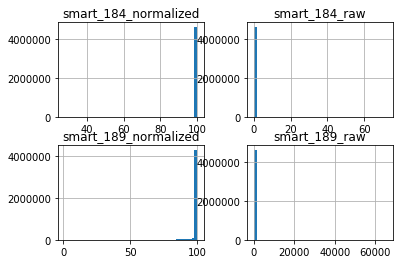

In [43]:
# histograms to visualize anything unusual
sub[['smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']].compute().hist(bins=50)

In [23]:
# get the data of the failed drives from the subset and see if there is any pattern in failed vs non failed
sub_failed = sub[['date', 'serial_number', 'smart_189_raw', 'smart_184_raw']][sub['serial_number'].isin(failed_serials)]
sub_working = sub[['date', 'serial_number', 'smart_189_raw', 'smart_184_raw']][~sub['serial_number'].isin(failed_serials)]

In [24]:
# are 184 and 189 simulataneously nan for all drives
print((sub_failed['smart_184_raw'].isna() == sub_failed['smart_189_raw'].isna()).all().compute())
print((sub_working['smart_184_raw'].isna() == sub_working['smart_189_raw'].isna()).all().compute())

[########################################] | 100% Completed | 49.5s
True
[########################################] | 100% Completed | 49.0s
True


**NOTE:** 189 and 184 are nans simulataneously. So we can use just one of the two for indexing into the data for analysis.

In [25]:
# from the subset, get serial numbers where 184 is nan, for failed drives
sub_failed_nanserials = sub_failed[sub_failed['smart_184_raw'].isna()]['serial_number'].unique().compute()
print(sub_failed_nanserials.shape)

# from the subset, get serial numbers where 184 is nan, for working drives
sub_working_nanserials = sub_working[sub_working['smart_184_raw'].isna()]['serial_number'].unique().compute()
print(sub_working_nanserials.shape)

[########################################] | 100% Completed | 51.2s
(86,)
[########################################] | 100% Completed | 53.4s
(26301,)


In [26]:
# how many drives in cleaned version of dataset
# this should be same as in whole dataset - i.e. we shouldn't have removed ALL the data for a drive yet
print(clean_df['serial_number'].drop_duplicates().isin(failed_serials).sum().compute())
print(seagate_df['serial_number'].drop_duplicates().isin(failed_serials).sum().compute())

[########################################] | 100% Completed | 50.5s
304
[########################################] | 100% Completed | 42.3s
304


**NOTE:** The number of serial nums where 184 (and 189) is nan is a significant portion of the total number of serial nums. (143 out of 341)

In [27]:
# for each serial number, what percentage of values in the time series are nans?
# this is to confirm a hunch - drives have either all values as nans or no values as nans 
failed_nanpercent = sub_failed[['serial_number', 'smart_184_raw']].groupby('serial_number').apply(lambda group: group['smart_184_raw'].isna().sum() / group.shape[0])
working_nanpercent = sub_working[['serial_number', 'smart_184_raw']].groupby('serial_number').apply(lambda group: group['smart_184_raw'].isna().sum() / group.shape[0])

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [28]:
# how many failed drives are there which have neither all-nan nor no-nan
failed_nanpercent[(failed_nanpercent != 1) & (failed_nanpercent != 0)].compute()    # S3010MAK, S3010LHR
# sub_failed[sub_failed['serial_number']=='S3010MAK'].compute()    # 1 nan value out of 19
# sub_failed[sub_failed['serial_number']=='S3010LHR'].compute()    # 1 nan value out of 14

[########################################] | 100% Completed | 57.0s


Series([], dtype: float64)

In [29]:
# how many working drives are there which have neither all-nan nor no-nan
working_nanpercent[(working_nanpercent != 1) & (working_nanpercent != 0)].compute().sort_values(ascending=False)    # 87 values, max percent 0.011494/1.0
# sub_working[sub_working['serial_number']=='Z4D05N47'].compute()    # 1 nan value out of 92
# sub_working[sub_working['serial_number']=='S301090L'].compute()    # 1 nan value out of 87
# sub_working[sub_working['serial_number']=='S300Z4KY'].compute()    # 1 nan value out of 87

[########################################] | 100% Completed |  1min 21.4s


Series([], dtype: float64)

**RESULT:** The hunch was correct. For a given serial number, either all values are nans or less than 1% values are nans (often only one). Therefore we can approach this in a hybrid way.

For minimal nans, the data can be interpolated or mean/mode/median/forward/backward filled, since this could have likely come from a hiccup in data collection.

For all-nans, it can be filled with dummy value so that model knows that a particular serial/model provides only nans for this smart stat.

**Attempt 1:** In the cells below, we try to group by serial number. Then, check if that serial number always reports nans. If yes, then fill it with dummy value and if not, interpolate.

However, this does not work well with dask dataframe because of duplicate indexing issue.

In [110]:
# def inter0(group):
#     ret = group.reset_index().interpolate()
#     ret.index = ret['index']
#     ret.index.name = None
#     ret = ret.drop(['index', 'serial_number'], axis=1)
#     return ret

# def inter1(group):
#     breakpoint()
#     return group.interpolate()

# # tmp = clean_df[['serial_number', 'smart_184_raw']].repartition(npartitions=24)
# # tmp = tmp.groupby('serial_number').apply(lambda group: group.interpolate())
# # tmp = tmp.groupby('serial_number').apply(interpolate_fun)
# # tmp = tmp.groupby('serial_number').apply(lambda group: group.reset_index().ffill())
# # tmp = tmp.groupby('serial_number').apply(inter1)

In [87]:
##################### WORKING BUT LESS ACCURATE #####################
# tmp = clean_df[clean_df['serial_number'].isin(['S2ZYJ9FG404837', 'S2ZYJ9CG107997', 'S2ZYJ9CFC01460'])]
# res = tmp[['serial_number', 'smart_184_raw']].groupby('serial_number').apply(lambda group: group.fillna(value=-100))
# clean_df = clean_df.groupby('serial_number').apply(lambda group: group.interpolate(method='linear'))
# clean_df = clean_df.groupby('serial_number').apply(lambda group: group.fillna(value=DUMMY_VALUE))
# res = res.groupby('serial_number').apply(lambda group: group.fillna(value=-100))

# # interpolate missing values. all-nan columns will be unaffected
# clean_df = clean_df.groupby('serial_number').apply(lambda group: group.interpolate(method='linear'))

# # fill with -100 for the values that are still nan
# clean_df = clean_df.groupby('serial_number').apply(lambda group: group.fillna(value=-100))
##################### WORKING BUT LESS ACCURATE #####################

**Attempt 2:** Instead, lets try to fill na's on the entire df, but by using serial number isin. fillna on entire df is known to work ok and not raise the duplicate indices error like the previous cell does.

First get the serial numbers which always report nan. Then replace those nans with dummy value. Then, apply interpolation/mean/median/mode for the remaining values. Note that this may not be very accurate, since mean/median/mode may be different across models (even though vendor is the same).

In [30]:
# get all the serial numbers where 184 is seen to be nan at least once
nan184_serials = clean_df[clean_df['smart_184_raw'].isna()]['serial_number'].unique().compute()    # len = 32005

# of these serial numbers, which ones are the ones for whom 184 is always nan
# isallnan184_serials = clean_df[['serial_number', 'smart_184_raw']].groupby('serial_number').apply(lambda g: g['smart_184_raw'].isna().all())    # shape = (83628,)
isallnan184_serials = clean_df[clean_df['serial_number'].isin(nan184_serials)][['serial_number', 'smart_184_raw']]
isallnan184_serials = isallnan184_serials.groupby('serial_number').apply(lambda g: g['smart_184_raw'].isna().all())

[########################################] | 100% Completed | 44.0s


/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  import sys


In [31]:
# check which class is minority - this will be used for lookup using isin, for efficiency
isallnan184_serials.value_counts().compute()

[########################################] | 100% Completed |  1min  5.7s


True    26387
dtype: int64

In [32]:
# serial numbers which have all-nans for 184 and 189 and are therefore to be filled with dummy value
dummyfill_sers = isallnan184_serials[isallnan184_serials == True].index.compute()
dummyfill_sers

[########################################] | 100% Completed |  1min  6.7s


Index(['ZCH018KV', 'ZCH028E0', 'ZCH028RH', 'ZCH036H8', 'ZCH0447E', 'ZCH046XA',
       'ZCH050E0', 'ZCH0528B', 'ZCH053T4', 'ZCH05BTG',
       ...
       'ZJV10J7P', 'ZJV10J7T', 'ZJV10JBM', 'ZJV10W3L', 'ZJV121MR', 'ZJV121QN',
       'ZJV121XD', 'ZJV12R9J', 'ZJV137E2', 'ZJV1CSL8'],
      dtype='object', name='serial_number', length=26387)

In [33]:
# fill columns with dummy value
cols_to_fill = ['smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']
for col in cols_to_fill:
    clean_df[col] = clean_df[col].mask(clean_df['serial_number'].isin(dummyfill_sers), DUMMY_VALUE)
    
# how are things after this part
print(dd.compute(clean_df.shape)[0])
utils.get_nan_count_percent(clean_df).compute()

[########################################] | 100% Completed | 53.1s
(7092993, 38)
[########################################] | 100% Completed | 48.4s
[########################################] | 100% Completed | 49.0s


count   percent
date                      0  0.000000
serial_number             0  0.000000
capacity_bytes            0  0.000000
failure                   0  0.000000
smart_1_raw               0  0.000000
smart_5_raw               0  0.000000
smart_7_raw               0  0.000000
smart_9_raw               0  0.000000
smart_10_raw              0  0.000000
smart_184_raw             0  0.000000
smart_187_raw           268  0.000038
smart_188_raw           268  0.000038
smart_189_raw             0  0.000000
smart_190_raw           268  0.000038
smart_193_raw           268  0.000038
smart_194_raw             0  0.000000
smart_197_raw             0  0.000000
smart_198_raw             0  0.000000
smart_240_raw             0  0.000000
smart_241_raw             0  0.000000
smart_242_raw             0  0.000000
smart_1_normalized        0  0.000000
smart_5_normalized        0  0.000000
smart_7_normalized        0  0.000000
smart_9_normalized        0  0.000000
smart_10_normalized       0  0.000000
smart_184_normalized      0  0.000000
smart_187_normalized    268  0.000038
smart_188_normalized    268  0.000038
smart_189_normalized      0  0.000000
smart_190_normalized    268  0.000038
smart_193_normalized    268  0.000038
smart_194_normalized      0  0.000000
smart_197_normalized      0  0.000000
smart_198_normalized      0  0.000000
smart_240_normalized      0  0.000000
smart_241_normalized      0  0.000000
smart_242_normalized      0  0.000000

In [34]:
# collect garbage
del sub
del sub_failed
del sub_working
del dummyfill_sers
del nan184_serials
del isallnan184_serials
del sub_failed_nanserials
del sub_working_nanserials
del failed_nanpercent
del working_nanpercent
gc.collect()

1979

### Part 5: Finalize Remaining Nans

Nothing "smart" can be done about the nans that still remain (it may not be worth the effort anyway). So fill these with their mean values.

In [35]:
# fill nans with mean values
clean_df = clean_df.fillna(value=clean_df.mean())
print('Final shape =', dd.compute(clean_df.shape)[0])

# verify that there are no more nans
utils.get_nan_count_percent(clean_df).compute()

[########################################] | 100% Completed | 58.1s
Final shape = (7092993, 38)
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 48.9s


count  percent
date                      0      0.0
serial_number             0      0.0
capacity_bytes            0      0.0
failure                   0      0.0
smart_1_raw               0      0.0
smart_5_raw               0      0.0
smart_7_raw               0      0.0
smart_9_raw               0      0.0
smart_10_raw              0      0.0
smart_184_raw             0      0.0
smart_187_raw             0      0.0
smart_188_raw             0      0.0
smart_189_raw             0      0.0
smart_190_raw             0      0.0
smart_193_raw             0      0.0
smart_194_raw             0      0.0
smart_197_raw             0      0.0
smart_198_raw             0      0.0
smart_240_raw             0      0.0
smart_241_raw             0      0.0
smart_242_raw             0      0.0
smart_1_normalized        0      0.0
smart_5_normalized        0      0.0
smart_7_normalized        0      0.0
smart_9_normalized        0      0.0
smart_10_normalized       0      0.0
smart_184_normalized      0      0.0
smart_187_normalized      0      0.0
smart_188_normalized      0      0.0
smart_189_normalized      0      0.0
smart_190_normalized      0      0.0
smart_193_normalized      0      0.0
smart_194_normalized      0      0.0
smart_197_normalized      0      0.0
smart_198_normalized      0      0.0
smart_240_normalized      0      0.0
smart_241_normalized      0      0.0
smart_242_normalized      0      0.0

## Repartition and Save
The size of dataset may have changed after cleanup, so repartition for efficiency, and then save to disk so that cleanup does not have to be done every time for experimentation.
According to Dask docs, the ideal size of a partition is around 100 MB (source: https://docs.dask.org/en/latest/dataframe-best-practices.html)

In [36]:
# get ideal number of partitions
PARTITION_SIZE_BYTES = 100 * 10**6
DF_SIZE_BYTES = clean_df.memory_usage(deep=True).sum().compute()
NUM_PARTITIONS = int(np.ceil(DF_SIZE_BYTES / PARTITION_SIZE_BYTES))

# repartition and save cleaned version of data
clean_df = clean_df.repartition(npartitions=NUM_PARTITIONS)

# create save dir as same name as data dir, but suffixed with "_clean"
head, tail = os.path.split(os.path.normpath(DATA_DIR))
save_dir = os.path.join(head, tail+'_seagate_clean')

# if path doesnt exist, mkdir
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# save partitions
clean_df.to_csv(os.path.join(save_dir, 'partition_*.csv'), index=False)

[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  3min 32.6s


['/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_00.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_01.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_02.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_03.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_04.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_05.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_06.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_07.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_08.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_09.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_10.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_11.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_clean/partition_12.csv',
 '/home/kachauha/Downloads/data_Q3_2018_seagate_cle

In [37]:
# unregister dask compute call progress bar
pbar.unregister()